## This Notebook calculates the number of genes mentioned in the GPT 4 analysis paragraph 

In [2]:
def get_LLM_gene_count(genes_fixed, LLM_analysis):
    system_genes_set = set(genes_fixed.split(" "))
    # Count the number of genes in the set that are mentioned in the LLM analysis
    overlaps = sum(1 for system_gene in system_genes_set if system_gene in LLM_analysis) 
    return overlaps

In [3]:
import pandas as pd
df = pd.read_csv('./data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')

perc_gene_mentioned = []
counts = []
for ind, row in df.iterrows():
    genes = row['Genes']
    genecount = float(row['Gene_Count'])
    assert genecount == len(genes.split(" ")) # make sure the gene count is correct
    
    analysis = row['LLM Analysis']
    overlap_counts = get_LLM_gene_count(genes, analysis)
    counts.append(overlap_counts)
    perc_gene_mentioned.append(overlap_counts/genecount)

df['num_gene_mentioned'] = counts
df['perc_gene_mentioned'] = perc_gene_mentioned

df.to_csv('./data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t', index=False)

In [4]:
df['perc_gene_mentioned'].describe()

count    1000.000000
mean        0.811926
std         0.302239
min         0.015487
25%         0.638369
50%         1.000000
75%         1.000000
max         1.000000
Name: perc_gene_mentioned, dtype: float64

In [5]:
# find the number of times that covers at least 90% of the genes

print("Number of GO terms that cover at least 90% of the genes: {}".format(sum(1 for i in perc_gene_mentioned if i >= 0.9)))
print("Number of GO terms that cover at least 50% of the genes: {}".format(sum(1 for i in perc_gene_mentioned if i >= 0.5)))

Number of GO terms that cover at least 90% of the genes: 691
Number of GO terms that cover at least 50% of the genes: 796


In [6]:
#check the size of the GO terms for outliers
import numpy as np

# Calculate quartiles and IQR
q1 = np.percentile(df['perc_gene_mentioned'], 25)
q3 = np.percentile(df['perc_gene_mentioned'], 75)
iqr = q3 - q1

# Calculate the upper and lower bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Extract the outliers from the DataFrame
outliers = df[(df['perc_gene_mentioned'] < lower_bound) | (df['perc_gene_mentioned'] > upper_bound)]
print('lower bound: {}'.format(lower_bound))
print("Number of outliers: {}".format(len(outliers)))
# outliers size distribution
outliers['Gene_Count'].describe()

lower bound: 0.09592245989304826
Number of outliers: 27


count     27.000000
mean     281.703704
std      109.846682
min       69.000000
25%      184.000000
50%      303.000000
75%      362.000000
max      456.000000
Name: Gene_Count, dtype: float64

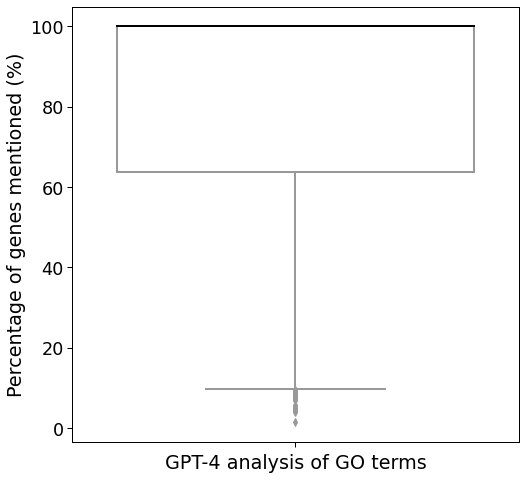

In [7]:
## plot a box plot 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.read_csv('./data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')
perc_gene_mentioned = df['perc_gene_mentioned'].tolist()
sns.set_context("paper", font_scale=2)
plt.rcParams['pdf.fonttype'] = 42
fig,ax = plt.subplots(figsize=(8,8))

box_plot = sns.boxplot(y=[frac *100 for frac in perc_gene_mentioned], ax=ax, color='white', linewidth=2)

# changing color and linewidth of the median line
median_line = box_plot.get_lines()[4] # get the median line
median_line.set_color('black') # change the color
median_line.set_linewidth(2) # change the linewidth

ax.set_ylabel("Percentage of genes mentioned (%)")
ax.set_xlabel("GPT-4 analysis of GO terms")

# plt.savefig('./figures/LLM_gene_mention_percentage.pdf', dpi = 300,bbox_inches='tight')
plt.show()